In [298]:
%matplotlib widget

from sklearn.datasets import load_iris
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [299]:
# load the full dataset and display it
dataset = load_iris()
names = dataset.feature_names
data = dataset.data
target = dataset.target

In [300]:
# preprocess the data to remove the third category so we have binary classification for now
index = np.searchsorted(target, 2)

data = data[:index]
target = target[:index].astype(np.float64) # convert to float64

data = data[:,:2] # use only 2 features
names = names[:2] # use only 2 features

print(names)
print("Data: ", data.shape, data.dtype)
print("Target:", target.shape, target.dtype)

print(data)
print(target)

['sepal length (cm)', 'sepal width (cm)']
Data:  (100, 2) float64
Target: (100,) float64
[[5.1 3.5]
 [4.9 3. ]
 [4.7 3.2]
 [4.6 3.1]
 [5.  3.6]
 [5.4 3.9]
 [4.6 3.4]
 [5.  3.4]
 [4.4 2.9]
 [4.9 3.1]
 [5.4 3.7]
 [4.8 3.4]
 [4.8 3. ]
 [4.3 3. ]
 [5.8 4. ]
 [5.7 4.4]
 [5.4 3.9]
 [5.1 3.5]
 [5.7 3.8]
 [5.1 3.8]
 [5.4 3.4]
 [5.1 3.7]
 [4.6 3.6]
 [5.1 3.3]
 [4.8 3.4]
 [5.  3. ]
 [5.  3.4]
 [5.2 3.5]
 [5.2 3.4]
 [4.7 3.2]
 [4.8 3.1]
 [5.4 3.4]
 [5.2 4.1]
 [5.5 4.2]
 [4.9 3.1]
 [5.  3.2]
 [5.5 3.5]
 [4.9 3.6]
 [4.4 3. ]
 [5.1 3.4]
 [5.  3.5]
 [4.5 2.3]
 [4.4 3.2]
 [5.  3.5]
 [5.1 3.8]
 [4.8 3. ]
 [5.1 3.8]
 [4.6 3.2]
 [5.3 3.7]
 [5.  3.3]
 [7.  3.2]
 [6.4 3.2]
 [6.9 3.1]
 [5.5 2.3]
 [6.5 2.8]
 [5.7 2.8]
 [6.3 3.3]
 [4.9 2.4]
 [6.6 2.9]
 [5.2 2.7]
 [5.  2. ]
 [5.9 3. ]
 [6.  2.2]
 [6.1 2.9]
 [5.6 2.9]
 [6.7 3.1]
 [5.6 3. ]
 [5.8 2.7]
 [6.2 2.2]
 [5.6 2.5]
 [5.9 3.2]
 [6.1 2.8]
 [6.3 2.5]
 [6.1 2.8]
 [6.4 2.9]
 [6.6 3. ]
 [6.8 2.8]
 [6.7 3. ]
 [6.  2.9]
 [5.7 2.6]
 [5.5 2.4]
 [5.5 2.4]
 [5.8 2.7

In [301]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [302]:
def predict(w,b,x):
    prediction = np.matmul(x, w) + b
    
    return sigmoid(prediction) # pass it through a sigmoid

In [303]:
def log_loss_cost(w,b,x,y, epsilon=1e-15):
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features
    
    prediction = sigmoid(np.matmul(x, w) + b) # mx1
    prediction = np.clip(prediction, epsilon, 1 - epsilon) # clip prediction to avoid overflow issues
    error = y * np.log(prediction) + (1 - y) * np.log(1 - prediction) # use logistic loss function
    error = error.reshape((-1)) # m
    
    return np.sum(error) / -m

In [304]:
def compute_loss_gradients(w,b,x,y):
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features

    prediction = sigmoid(np.matmul(x, w) + b) # mx1
    error = prediction - y # mx1
    
    xT = np.transpose(x) # nxm
    dw = np.matmul(xT, error) / m # nx1
    db = np.sum(error) / m # 1

    return dw, db

In [305]:
def feature_scale(data_unscaled, scaled=True):
    if scaled == False:
        return data_unscaled

    mu = np.mean(data_unscaled, axis=0)
    std = np.std(data_unscaled, axis=0)

    data_scaled = np.array(data_unscaled)
    data_scaled = (data_scaled - mu) / std
    # z score normalization
    
    return data_scaled

data = feature_scale(data, scaled=True)

In [306]:
def show_cost_graph(costs, title, color):
    iterations = costs.shape[0]
    iteration_array = np.arange(0, iterations, dtype=np.int32)
    
    # graph the cost after updating the model
    fig, cost_graph = plt.subplots(layout='constrained')
    
    cost_graph.set_xlabel("Current Iteration")
    cost_graph.set_ylabel("Cost")
    
    cost_graph.set_title(title)
    
    cost_graph.plot(iteration_array, costs, color=color)

In [307]:
def gradient_descent(x, y, gradient_func, cost_func, learning_rate=0.01, max_iterations=1000):
    y = y.reshape((-1,1))
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features
    
    w = np.zeros((n,1)) # n features
    b = 0
    # initialize model parameters to zeroes
    
    costs = np.empty(0)

    for i in range(max_iterations):
        dw, db = gradient_func(w,b,x,y)
        
        w -= learning_rate * dw
        b -= learning_rate * db
        # update the weights
        
        current_cost = cost_func(w,b,x,y)
        costs = np.append(costs, current_cost)
        # add to array for visualization
    return w, b, costs
weights, intercept, standard_costs = gradient_descent(data, target, compute_loss_gradients, log_loss_cost, learning_rate=0.1, max_iterations=10000)

In [308]:
frange=3
samples=200
x = np.linspace(-frange,frange,samples)
y = np.linspace(-frange,frange,samples)
nx, ny = np.meshgrid(x, y)
xpoints = np.array([nx.ravel(),ny.ravel()]).T
prediction = predict(weights,intercept,xpoints)
classification = np.round(prediction).reshape((samples,-1))

index = np.searchsorted(target, 1)
data0 = data[:index,:]
data1 = data[index:,:]

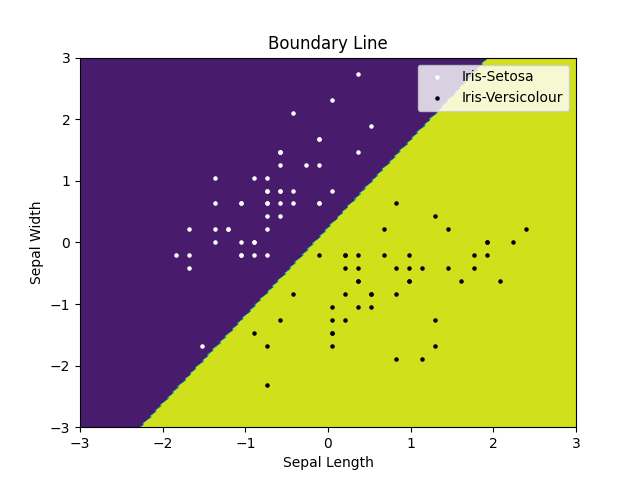

In [309]:
fig,ax = plt.subplots()
ax.set_xlabel("Sepal Length")
ax.set_ylabel("Sepal Width")
ax.set_title("Boundary Line")
ax.contourf(nx,ny,classification)
ax.scatter(data0[:,0],data0[:,1],c='white',label="Iris-Setosa",s=5)
ax.scatter(data1[:,0],data1[:,1],c='black',label="Iris-Versicolour",s=5)
ax.legend()

As we can see, the boundary line is very clean. The typical way to plot these boundaries is to use two features and plot the boundary that separates the two classifications. And clearly the boundary line estimates good. 

In [311]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(data, target)
scikit_predict = clf.predict(data)

errors = np.sum(np.abs(scikit_predict - target.reshape(-1)))
print("Misclassifications:", errors)

Misclassifications: 0.0


Great we have no errors from scikit. Let's re plot the boundary of scikit and see how it compares with our boundary line.

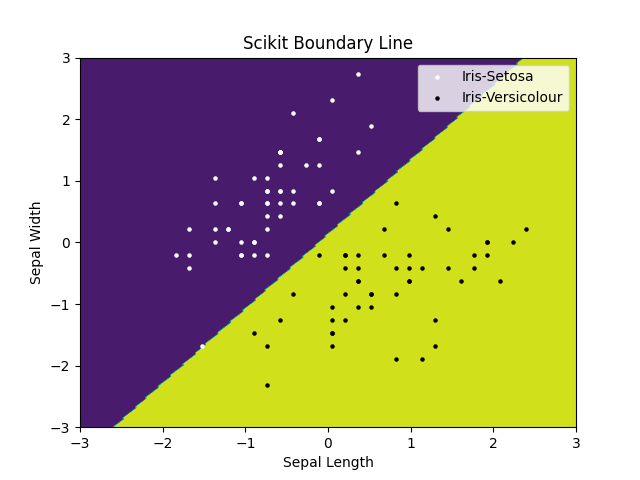

In [312]:
scikit_classification = clf.predict(xpoints).reshape((samples,-1))

fig, ax = plt.subplots()
ax.set_xlabel("Sepal Length")
ax.set_ylabel("Sepal Width")
ax.set_title("Scikit Boundary Line")
ax.contourf(nx,ny,scikit_classification)
ax.scatter(data0[:,0],data0[:,1],c='white',label="Iris-Setosa",s=5)
ax.scatter(data1[:,0],data1[:,1],c='black',label="Iris-Versicolour",s=5)
ax.legend()

Cool, it looks very similar to ours but there is a small difference and it's clear after observing the visualizations for awhile. These differences are probably feature normalization which we can ignore for now. This shows that we predict very accurately just like scikit.